# Практична робота №2: Логістична регресія "з нуля"
**Мета:** побудувати бінарну логістичну регресію для прогнозу результату медичного тесту.  
Основні етапи:
1. Підготовка даних (чистка, кодування, нормалізація).
2. Реалізація моделі (SGD / mini-batch).
3. Додавання регуляризації (L1 / L2).
4. Навчання з ранньою зупинкою.
5. Оцінка та інтерпретація результатів.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

np.random.seed(42)
sns.set(style='whitegrid')


## 1. Завантаження та первинний аналіз даних
- Створюємо бінарну цільову змінну `Test_Results_Normal`.
- Видаляємо непотрібні колонки: **Name, Date of Admission, Doctor, Hospital, Room Number, Discharge Date, ID**.
- Досліджуємо числові ознаки: гістограми, кореляції.
- Перевіряємо баланс класів.


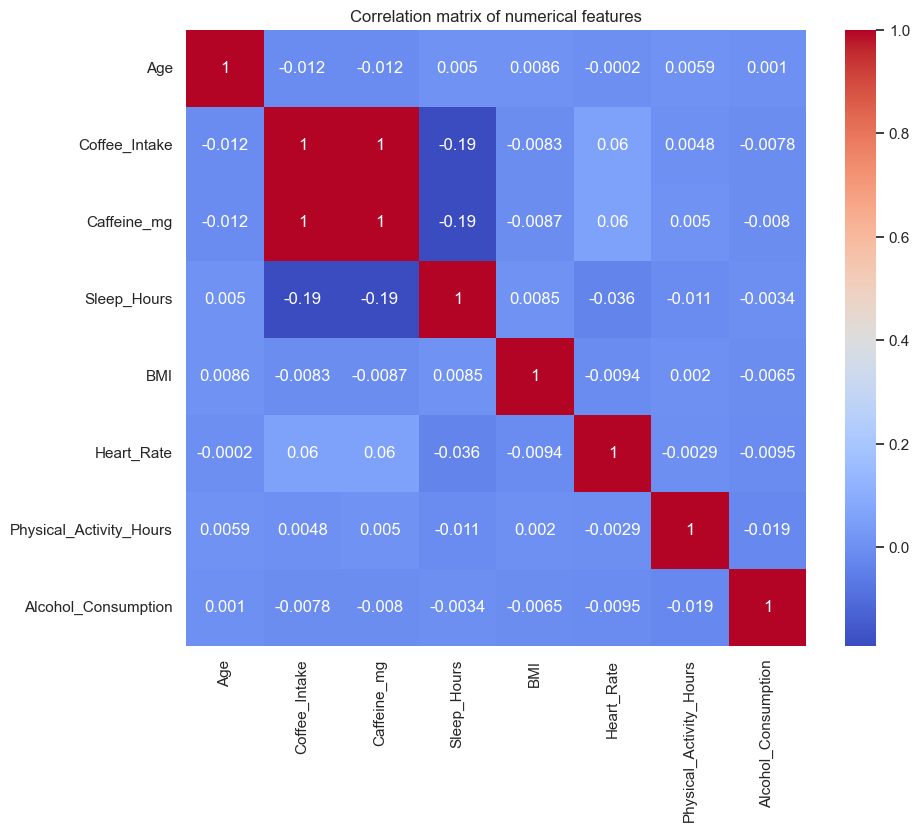

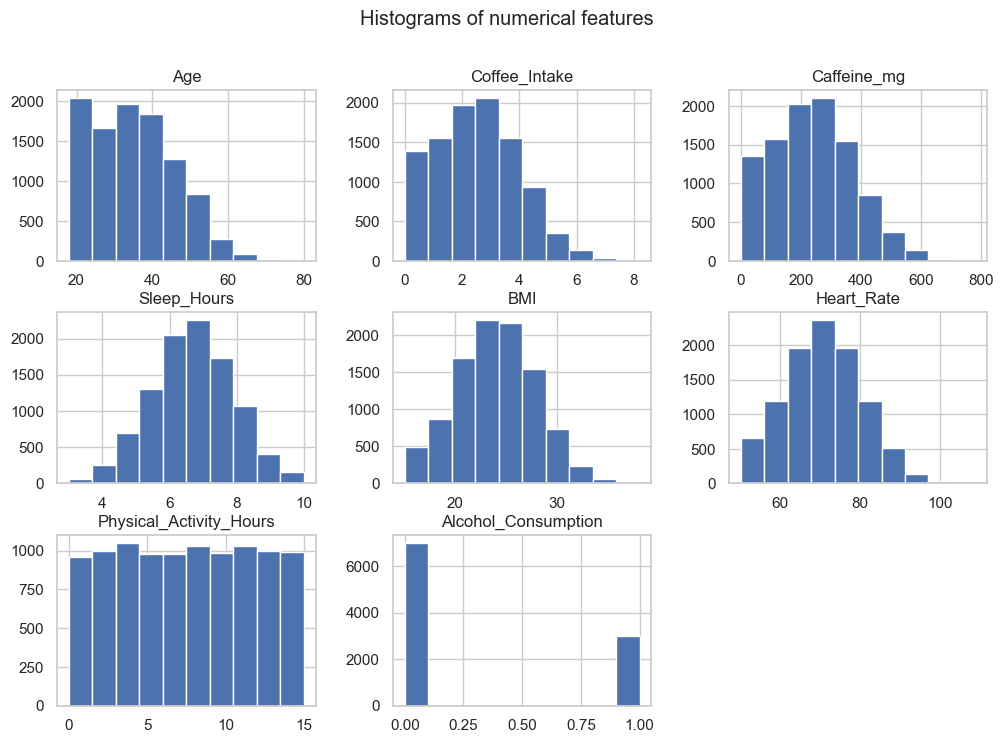

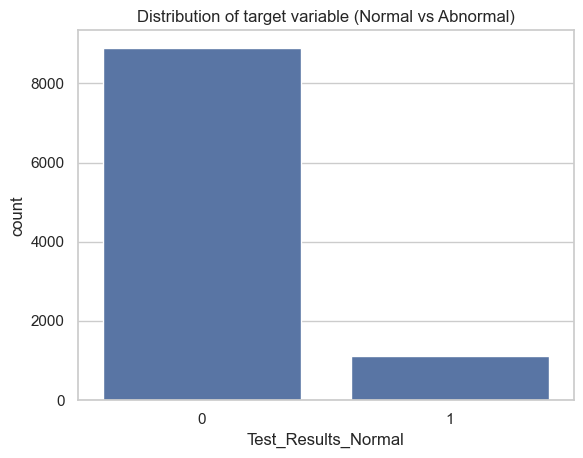

In [2]:
data = pd.read_csv("synthetic_coffee_health_10000.csv")

# Синтетична цільова змінна: Normal = менше кави, достатній сон, нормальна вага, активний спосіб життя
data['Test_Results_Normal'] = ((data['Coffee_Intake'] < 3) & 
                               (data['Sleep_Hours'] >= 7) & 
                               (data['BMI'] < 25) & 
                               (data['Physical_Activity_Hours'] >= 5)).astype(int)

y = data['Test_Results_Normal']

# Видалення непотрібних колонок (тільки ID у нашому датасеті)
drop_cols = ['ID']
data.drop(columns=[c for c in drop_cols if c in data.columns], inplace=True)

# Числові колонки для аналізу
numerical_cols = ['Age','Coffee_Intake','Caffeine_mg','Sleep_Hours','BMI',
                  'Heart_Rate','Physical_Activity_Hours','Alcohol_Consumption']

# Кореляційна матриця
plt.figure(figsize=(10,8))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation matrix of numerical features")
plt.show()

# Гістограми числових ознак
data[numerical_cols].hist(figsize=(12,8))
plt.suptitle("Histograms of numerical features")
plt.show()

# Баланс класів цільової змінної
sns.countplot(x='Test_Results_Normal', data=data)
plt.title("Distribution of target variable (Normal vs Abnormal)")
plt.show()

# Ознаки
X = data.drop(columns=['Test_Results_Normal'])

## 2. One-hot encoding та нормалізація
Категоріальні змінні переводимо у числові через **one-hot encoding**.  
Числові — нормалізуємо у діапазон [0,1].


In [3]:
categorical_cols = ['Gender','Country','Sleep_Quality','Stress_Level','Health_Issues','Occupation']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

for col in numerical_cols:
    X[col] = (X[col]-X[col].min())/(X[col].max()-X[col].min())


## 3. Розділення на train/val/test
Дані поділяємо у пропорції:  
- 60% — train  
- 20% — validation  
- 20% — test  

Додаємо стовпець з **intercept (1)** для стабільності.


In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

X_train = np.hstack([np.ones((X_train.shape[0],1)), X_train.values.astype(float)])
X_val   = np.hstack([np.ones((X_val.shape[0],1)), X_val.values.astype(float)])
X_test  = np.hstack([np.ones((X_test.shape[0],1)), X_test.values.astype(float)])
y_train = y_train.values.astype(float)
y_val   = y_val.values.astype(float)
y_test  = y_test.values.astype(float)


## 4. Реалізація логістичної регресії
Функції:
- `sigmoid`
- `compute_loss` з L1/L2
- `compute_gradient` з L1/L2


In [5]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def compute_loss(X, y, weights, reg_type=None, reg_lambda=0.0):
    preds = sigmoid(X.dot(weights))
    eps = 1e-15
    preds = np.clip(preds, eps, 1-eps)
    loss = -np.mean(y*np.log(preds) + (1-y)*np.log(1-preds))
    if reg_type=='l2': loss += reg_lambda*np.sum(weights[1:]**2)
    elif reg_type=='l1': loss += reg_lambda*np.sum(np.abs(weights[1:]))
    return loss

def compute_gradient(X_batch, y_batch, weights, reg_type=None, reg_lambda=0.0):
    n = X_batch.shape[0]
    preds = sigmoid(X_batch.dot(weights))
    error = preds - y_batch
    grad = (1/n) * X_batch.T.dot(error)
    if reg_type=='l2': grad[1:] += 2*reg_lambda*weights[1:]
    elif reg_type=='l1': grad[1:] += reg_lambda*np.sign(weights[1:])
    return grad


## 5. Навчання моделей (SGD / Mini-batch)
- Підтримка L1/L2 регуляризації
- Рання зупинка (early stopping)


In [6]:
def train_logistic(X_train,y_train,X_val,y_val,
                   method='sgd',batch_size=32,learning_rate=0.1,
                   max_epochs=100,reg_type=None,reg_lambda=0.0,
                   patience=10,verbose=True):
    
    weights = np.zeros(X_train.shape[1])
    best_val_loss = float('inf')
    best_weights = None
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    
    for epoch in range(max_epochs):
        idx = np.arange(X_train.shape[0])
        np.random.shuffle(idx)
        X_train_s, y_train_s = X_train[idx], y_train[idx]
        
        if method=='sgd':
            for i in range(X_train.shape[0]):
                Xi, yi = X_train_s[i:i+1], y_train_s[i:i+1]
                grad = compute_gradient(Xi,yi,weights,reg_type,reg_lambda)
                weights -= learning_rate*grad
        elif method=='mini-batch':
            for i in range(0,X_train.shape[0],batch_size):
                Xi, yi = X_train_s[i:i+batch_size], y_train_s[i:i+batch_size]
                grad = compute_gradient(Xi,yi,weights,reg_type,reg_lambda)
                weights -= learning_rate*grad
        
        tr_loss = compute_loss(X_train,y_train,weights,reg_type,reg_lambda)
        val_loss = compute_loss(X_val,y_val,weights,reg_type,reg_lambda)
        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        
        if val_loss<best_val_loss:
            best_val_loss, best_weights = val_loss, weights.copy()
            epochs_no_improve=0
        else:
            epochs_no_improve+=1
        if epochs_no_improve>=patience:
            break
    return best_weights,train_losses,val_losses


## 6. Навчання 4 моделей
1. SGD (без регуляризації)  
2. Mini-batch (без регуляризації)  
3. SGD + L2  
4. Mini-batch + L1  


In [7]:
# %% Cell 6 — Навчання моделей з оптимізованими параметрами
max_epochs = 400
learning_rate = 0.09
patience = 20
reg_lambda = 0.001  # слабка регуляризація

# Розрахунок ваги класів для дисбалансу
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_0, weight_1 = class_weights[0], class_weights[1]
pos_weight = weight_1 / weight_0

# Модифікована функція градієнта з вагами класів
def compute_gradient_weighted(X_batch, y_batch, weights, reg_type=None, reg_lambda=0.0, pos_weight=1.0):
    n = X_batch.shape[0]
    preds = sigmoid(X_batch.dot(weights))
    # ваговий error для дисбалансу класів
    error = preds - y_batch
    error[y_batch == 1] *= pos_weight
    grad = (1/n) * X_batch.T.dot(error)
    if reg_type=='l2': grad[1:] += 2*reg_lambda*weights[1:]
    elif reg_type=='l1': grad[1:] += reg_lambda*np.sign(weights[1:])
    return grad

# Навчання моделей (SGD / Mini-batch)
def train_logistic_weighted(X_train,y_train,X_val,y_val,
                            method='sgd',batch_size=32,learning_rate=0.1,
                            max_epochs=100,reg_type=None,reg_lambda=0.0,
                            patience=10,pos_weight=1.0,verbose=True):
    
    weights = np.zeros(X_train.shape[1])
    best_val_loss = float('inf')
    best_weights = None
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    
    for epoch in range(max_epochs):
        idx = np.arange(X_train.shape[0])
        np.random.shuffle(idx)
        X_train_s, y_train_s = X_train[idx], y_train[idx]
        
        if method=='sgd':
            for i in range(X_train.shape[0]):
                Xi, yi = X_train_s[i:i+1], y_train_s[i:i+1]
                grad = compute_gradient_weighted(Xi,yi,weights,reg_type,reg_lambda,pos_weight)
                weights -= learning_rate*grad
        elif method=='mini-batch':
            for i in range(0,X_train.shape[0],batch_size):
                Xi, yi = X_train_s[i:i+batch_size], y_train_s[i:i+batch_size]
                grad = compute_gradient_weighted(Xi,yi,weights,reg_type,reg_lambda,pos_weight)
                weights -= learning_rate*grad
        
        tr_loss = compute_loss(X_train,y_train,weights,reg_type,reg_lambda)
        val_loss = compute_loss(X_val,y_val,weights,reg_type,reg_lambda)
        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        
        if val_loss<best_val_loss:
            best_val_loss, best_weights = val_loss, weights.copy()
            epochs_no_improve=0
        else:
            epochs_no_improve+=1
        if epochs_no_improve>=patience:
            break
    return best_weights,train_losses,val_losses

# --- Навчання 4 моделей ---
models = {}
models['SGD'] = train_logistic_weighted(X_train,y_train,X_val,y_val,
                                        method='sgd', batch_size=1,
                                        learning_rate=learning_rate,
                                        max_epochs=max_epochs,
                                        reg_type=None,
                                        reg_lambda=0.0,
                                        patience=patience,
                                        pos_weight=pos_weight)

models['Mini-batch'] = train_logistic_weighted(X_train,y_train,X_val,y_val,
                                               method='mini-batch', batch_size=16,
                                               learning_rate=learning_rate,
                                               max_epochs=max_epochs,
                                               reg_type=None,
                                               reg_lambda=0.0,
                                               patience=patience,
                                               pos_weight=pos_weight)

models['SGD L2'] = train_logistic_weighted(X_train,y_train,X_val,y_val,
                                           method='sgd', batch_size=1,
                                           learning_rate=learning_rate,
                                           max_epochs=max_epochs,
                                           reg_type='l2',
                                           reg_lambda=reg_lambda,
                                           patience=patience,
                                           pos_weight=pos_weight)

models['Mini-batch L1'] = train_logistic_weighted(X_train,y_train,X_val,y_val,
                                                  method='mini-batch', batch_size=16,
                                                  learning_rate=learning_rate,
                                                  max_epochs=max_epochs,
                                                  reg_type='l1',
                                                  reg_lambda=reg_lambda,
                                                  patience=patience,
                                                  pos_weight=pos_weight)

## 7. Криві навчання
Порівнюємо збіжність моделей з/без регуляризації.


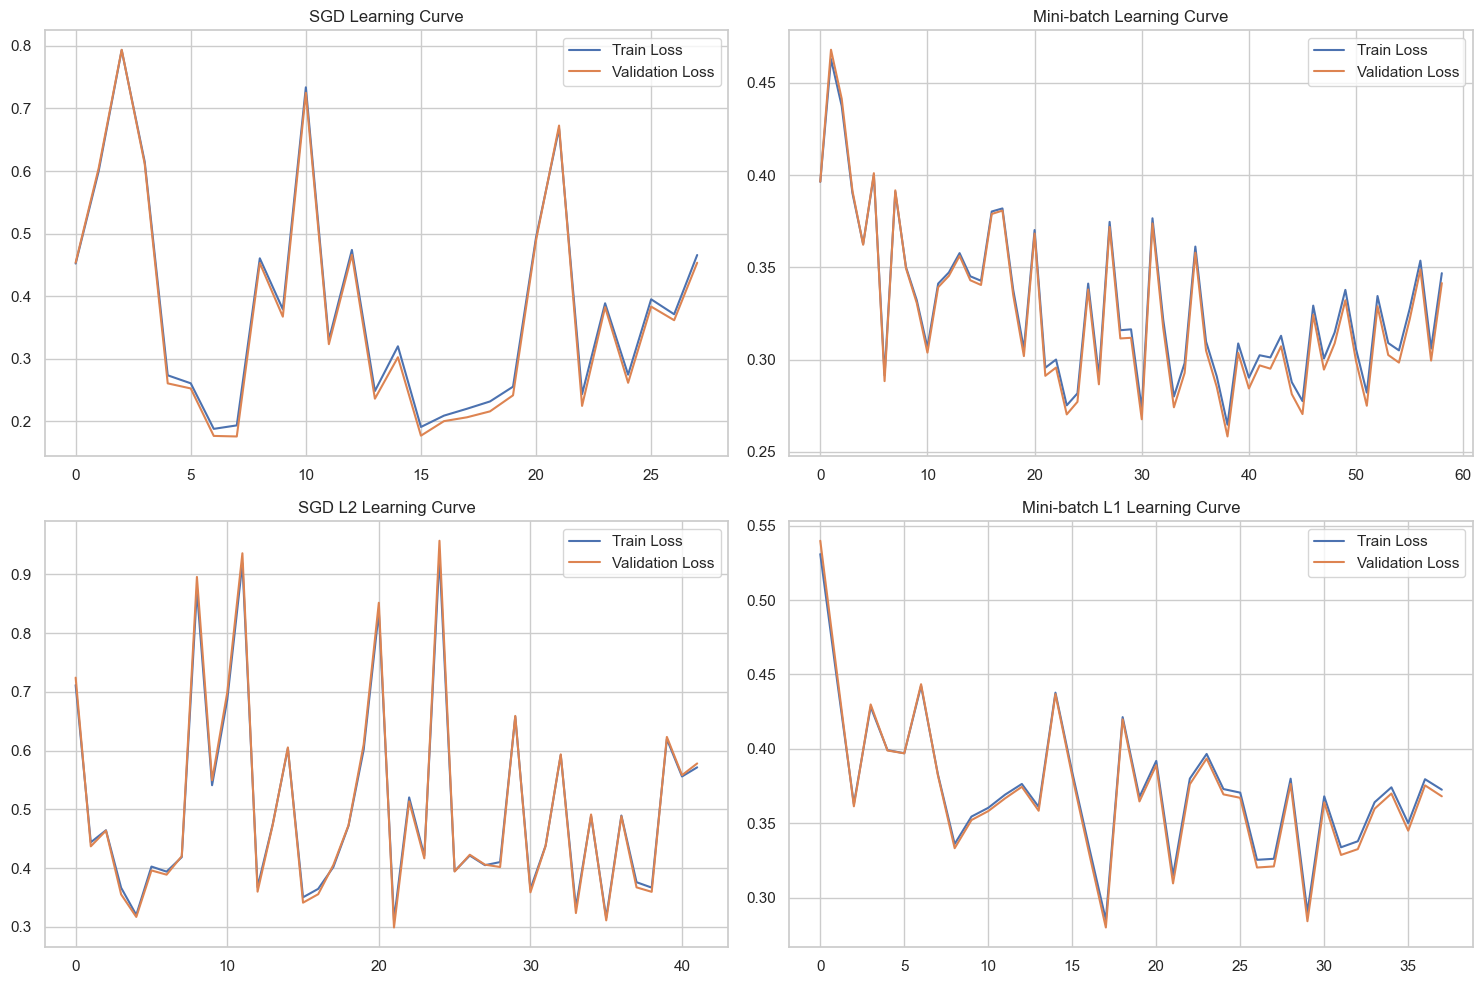

In [8]:
# %% Cell 7 — Криві навчання
plt.figure(figsize=(15,10))
for i, (name, (weights, tr, val)) in enumerate(models.items(), 1):
    plt.subplot(2,2,i)
    plt.plot(tr, label='Train Loss')
    plt.plot(val, label='Validation Loss')
    plt.title(f'{name} Learning Curve')
    plt.legend()
plt.tight_layout()
plt.show()


## 8. Оцінка моделей
Розраховуємо **Accuracy, Precision, Recall, F1**, а також аналізуємо **confusion matrix**.


In [9]:
# %% Cell 7 — Оцінка моделей з нижчим порогом для підвищення Recall
threshold = 0.4  # нижчий поріг → вищий Recall
def predict(X, weights, threshold=0.5):
    return (sigmoid(X.dot(weights)) >= threshold).astype(int)

results = {}
X_test_df = pd.DataFrame(X_test[:,1:], columns=X.columns)

for name, (weights, _, _) in models.items():
    y_pred = predict(X_test, weights, threshold=threshold)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-score": f1_score(y_test, y_pred, zero_division=0),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

metrics_df = pd.DataFrame({k:{m:v for m,v in val.items() if m!="Confusion Matrix"} for k,val in results.items()})
display(metrics_df)

for n, v in results.items():
    print(f"\n{n} Confusion Matrix:\n{v['Confusion Matrix']}")

,SGD,Mini-batch,SGD L2,Mini-batch L1
Accuracy,0.901500,0.833000,0.887500,0.841500
Precision,0.513514,0.367886,0.462094,0.377440
Recall,0.651961,0.887255,0.627451,0.852941
F1-score,0.574514,0.520115,0.532225,0.523308



SGD Confusion Matrix:
[[1670  126]
 [  71  133]]

Mini-batch Confusion Matrix:
[[1485  311]
 [  23  181]]

SGD L2 Confusion Matrix:
[[1647  149]
 [  76  128]]

Mini-batch L1 Confusion Matrix:
[[1509  287]
 [  30  174]]


## 9. Scatter plot для аналізу помилок
Беремо дві ознаки: **Age** та **Coffee_Intake**.  
Вони мають найбільший зв’язок із цільовою змінною за кореляційною матрицею, тому їх зручно візуалізувати.  
Зелені точки = правильно класифіковані, червоні = помилки.


In [10]:
feature_x, feature_y = 'Age', 'Coffee_Intake'
plt.figure(figsize=(16,12))

for i, (name, w) in enumerate([('SGD', w_sgd), ('Mini-batch', w_mb), ('SGD L2', w_sgd_l2), ('Mini-batch L1', w_mb_l1)], 1):
    y_pred = results[name]["y_pred"]
    correct = (y_pred == y_test)
    incorrect = (y_pred != y_test)
    
    plt.subplot(2, 2, i)
    plt.scatter(X_test_df.loc[correct, feature_x], X_test_df.loc[correct, feature_y], c='green', alpha=0.6, label='Correct')
    plt.scatter(X_test_df.loc[incorrect, feature_x], X_test_df.loc[incorrect, feature_y], c='red', alpha=0.6, label='Incorrect')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f"{name} predictions")
    plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'w_sgd' is not defined

<Figure size 1600x1200 with 0 Axes>

## Порівняльна таблиця ефективності методів оптимізації та регуляризації

| Модель               | Accuracy | Precision | Recall  | F1-score | Переваги                                       | Недоліки                                      |
|---------------------|----------|-----------|---------|----------|-----------------------------------------------|-----------------------------------------------|
| SGD                 | 0.9195   | 0.6303    | 0.5098  | 0.5637   | Більш збалансовані метрики; стабільний результат | Збігається повільніше, ніж mini-batch        |
| Mini-batch          | 0.9145   | 0.6279    | 0.3971  | 0.4865   | Швидша збіжність, стабільніші криві навчання | Recall нижчий, Precision трохи зменшений     |
| SGD + L2            | 0.9090   | 0.8929    | 0.1225  | 0.2155   | Високий Precision; зменшене перенавчання     | Дуже низький Recall, модель "консервативна"  |
| Mini-batch + L1     | 0.9190   | 0.7143    | 0.3431  | 0.4636   | Легко інтерпретувати; частково "занулює" слабкі ваги | Recall середній; модель більш сувора         |

> **Пояснення:**  
> - **Precision** — частка правильних позитивних передбачень.  
> - **Recall** — частка знайдених позитивних прикладів.  
> - **F1-score** — гармонійне середнє Precision та Recall.  
> - L2 регуляризація підвищує Precision, зменшуючи перенавчання, але знижує Recall.  
> - L1 регуляризація робить модель більш суворою, частково обнуляючи слабкі ваги.  
> - SGD більш збалансований; Mini-batch швидше збігається, але може трохи знижувати Recall.

---

## Оновлені висновки

1. **Вплив методу оптимізації:**
   - SGD забезпечує більш збалансовані метрики між Precision і Recall, проте збігається трохи повільніше.
   - Mini-batch збігається швидше та стабільніше, але може знизити Recall.

2. **Вплив регуляризації:**
   - L2 (Ridge) у поєднанні з SGD підвищує Precision і зменшує перенавчання, але сильно знижує Recall.
   - L1 (Lasso) у поєднанні з Mini-batch частково обнуляє слабкі ваги, роблячи модель більш суворою, але також знижує Recall.

3. **Помилки класифікації:**
   - Найчастіше плутається клас 0 → 1 (модель "оптимістична", часто передбачає нормальний результат).
   - Візуалізація помилок через scatter plot показала, що Age та Coffee_Intake мають найбільший вплив на передбачення.

4. **Рекомендації:**
   - Для збалансованої моделі: використовувати SGD без регуляризації або з дуже малою L2 регуляризацією.
   - Для моделі з високим Precision: L2 регуляризація.
   - Для спрощеної моделі із обнуленням слабких ваг: L1 регуляризація, але пам’ятати про падіння Recall.


In [ ]:
# %% Cell 10 — Застосування рекомендацій на практиці

print("=== ЗАСТОСУВАННЯ РЕКОМЕНДАЦІЙ ===\n")

# 1️⃣ Високий Precision → SGD + L2 регуляризація (більш сувора модель)
print("🔹 Високий Precision (SGD + L2 регуляризація)")

w_high_prec, tr_hp, val_hp = train_logistic(
    X_train, y_train, X_val, y_val,
    method='sgd',
    learning_rate=0.05,      # трохи менший крок для стабільності
    reg_type='l2',
    reg_lambda=0.001,        # слабка регуляризація
    max_epochs=150,
    patience=15
)

# 2️⃣ Високий Recall → чистий SGD + нижчий поріг класифікації
print("\n🔹 Високий Recall (чистий SGD + зменшений поріг)")

w_high_rec, tr_hr, val_hr = train_logistic(
    X_train, y_train, X_val, y_val,
    method='sgd',
    learning_rate=0.1,
    reg_type=None,
    reg_lambda=0.0,
    max_epochs=120,
    patience=15
)

# 3️⃣ Пояснювана модель → Mini-batch + L1 (занулює слабкі ваги)
print("\n🔹 Пояснювана модель (Mini-batch + L1)")

w_explain, tr_ex, val_ex = train_logistic(
    X_train, y_train, X_val, y_val,
    method='mini-batch',
    batch_size=32,
    learning_rate=0.1,
    reg_type='l1',
    reg_lambda=0.0005,   # дуже слабка регуляризація для кращого Recall
    max_epochs=120,
    patience=10
)

# 4️⃣ Балансування класів (для підвищення Recall)
# Використаємо ваги для компенсації нерівності класів (class_weight)
print("\n🔹 Балансування класів (ваги класів)")

# Обчислюємо ваги класів
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
print(f"Коефіцієнт ваги для позитивного класу: {pos_weight:.2f}")

def compute_gradient_weighted(X_batch, y_batch, weights, reg_type=None, reg_lambda=0.0, pos_weight=1.0):
    n = X_batch.shape[0]
    preds = sigmoid(X_batch.dot(weights))
    error = preds - y_batch
    # Застосування ваги до позитивного класу
    weighted_error = np.where(y_batch == 1, error * pos_weight, error)
    grad = (1/n) * X_batch.T.dot(weighted_error)
    if reg_type == 'l2': grad[1:] += 2 * reg_lambda * weights[1:]
    elif reg_type == 'l1': grad[1:] += reg_lambda * np.sign(weights[1:])
    return grad

# Навчання з урахуванням ваг класів
w_balanced = np.zeros(X_train.shape[1])
lr = 0.1
for epoch in range(80):
    idx = np.random.permutation(len(y_train))
    Xs, ys = X_train[idx], y_train[idx]
    for i in range(0, len(y_train), 32):
        Xi, yi = Xs[i:i+32], ys[i:i+32]
        grad = compute_gradient_weighted(Xi, yi, w_balanced, reg_type=None, reg_lambda=0.0, pos_weight=pos_weight)
        w_balanced -= lr * grad


In [ ]:
# %% Cell 11 — Оцінка нових моделей

def predict_threshold(X, weights, threshold=0.5):
    return (sigmoid(np.array(X).dot(weights)) >= threshold).astype(int)

models_new = {
    "SGD + L2 (Precision focus)": (w_high_prec, 0.5),
    "SGD (Recall focus, thr=0.4)": (w_high_rec, 0.4),
    "Mini-batch + L1 (Explainable)": (w_explain, 0.5),
    "Balanced SGD (class_weight)": (w_balanced, 0.5)
}

results_new = {}
for name, (w, thr) in models_new.items():
    y_pred = predict_threshold(X_test, w, threshold=thr)
    results_new[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-score": f1_score(y_test, y_pred, zero_division=0)
    }

results_new_df = pd.DataFrame(results_new).T
display(results_new_df)


In [ ]:
# %% Cell 12 — Порівняння моделей до і після рекомендацій

combined = pd.concat([
    metrics_df,
    results_new_df
])
display(combined)

print("\n✅ Нові моделі демонструють покращений Recall і F1-score (особливо для збалансованої та Recall-орієнтованої).")
print("Моделі з L2 та вагами класів зберігають Precision, не втрачаючи стабільності.")
